# Multiclass Classification
Tries to predict quadclass variable which has four classes measuring material cooperation (4), verbal cooperation (3), verbal conflict (2), and material conflict (1) from just URL string. Again, the aim here is to create a more efficient classifier for quadclass variable by just looking at the URL rather than running NLP on the entire story, which is what the GDELT project does to get these labels in the first place.

In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client

from dask.diagnostics import ProgressBar

from url_parser import parse_url

client = Client()

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 24,Total memory: 125.60 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36225,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 24
Started: Just now,Total memory: 125.60 GiB
Comm: tcp://127.0.0.1:35751,Total threads: 4
Dashboard: http://127.0.0.1:38429/status,Memory: 20.93 GiB
Nanny: tcp://127.0.0.1:43901,


In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

pbar = ProgressBar()
pbar.register()
# GDELT CodeBook: http://data.gdeltproject.org/documentation/CAMEO.Manual.1.1b3.pdf

In [4]:
dat = dd.read_parquet("data/output")

In [5]:
only_us = dat[(dat.Actor1Code == "USA") & (dat.Actor2Code == "CHN")]
only_china = dat[(dat.Actor1Code == "CHN") & (dat.Actor2Code == "USA")]
dat.head()

,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Religion1Code,Actor1Religion2Code,Actor1Type1Code,Actor1Type2Code,Actor1Type3Code,Actor2Code,Actor2Name,Actor2CountryCode,Actor2KnownGroupCode,Actor2EthnicCode,Actor2Religion1Code,Actor2Religion2Code,Actor2Type1Code,Actor2Type2Code,Actor2Type3Code,IsRootEvent,EventCode,EventBaseCode,EventRootCode,QuadClass,GoldsteinScale,NumMentions,NumSources,NumArticles,AvgTone,Actor1Geo_Type,Actor1Geo_FullName,Actor1Geo_CountryCode,Actor1Geo_ADM1Code,Actor1Geo_Lat,Actor1Geo_Long,Actor1Geo_FeatureID,Actor2Geo_Type,Actor2Geo_FullName,Actor2Geo_CountryCode,Actor2Geo_ADM1Code,Actor2Geo_Lat,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
GLOBALEVENTID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
963548206,20201211,202012,2020,2020.9342,USAEDU,UNITED STATES,USA,None,None,None,None,EDU,None,None,EDU,SCHOOL,None,None,None,None,None,EDU,None,None,0,030,030,03,1,4.0,2,1,2,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...
963548207,20210103,202101,2021,2021.0082,None,None,None,None,None,None,None,None,None,None,MIL,NATIONAL GUARD,None,None,None,None,None,MIL,None,None,1,036,036,03,1,4.0,70,5,70,-4.75240042017015,0,None,None,None,None,None,None,2,"California, United States",US,USCA,36.17,-119.746,CA,2,"California, United States",US,USCA,36.17,-119.746,CA,20210110,https://www.mdjonline.com/tribune/lifestyles/a...
963548213,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,GOV,SECRETARY OF STATE,None,None,None,None,None,GOV,None,None,0,020,020,02,1,3.0,142,38,142,-4.17371166647743,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,3,"Atlanta, Georgia, United States",US,USGA,33.749,-84.388,351615,20210110,https://accesswdun.com/article/2021/1/969753
963548214,20210103,202101,2021,2021.0082,USA,OREGON,USA,None,None,None,None,None,None,None,USAMIL,OREGON,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,6,1,6,1.01522842639594,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,3,"Washington, District of Columbia, United States",US,USDC,38.8951,-77.0364,531871,20210110,https://www.ktvb.com/article/news/health/coron...
963548215,20210103,202101,2021,2021.0082,USA,UNITED STATES,USA,None,None,None,None,None,None,None,USAMIL,UNITED STATES,USA,None,None,None,None,MIL,None,None,1,080,080,08,2,5.0,4,1,4,1.01522842639594,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,2,"Oregon, United States",US,USOR,44.5672,-122.127,OR,20210110,https://www.ktvb.com/article/news/health/coron...


In [6]:
topn = 100
urls = only_china[["SOURCEURL", "QuadClass"]].compute()
urls = urls.dropna()
print(urls)

                                                       SOURCEURL QuadClass
GLOBALEVENTID                                                             
963548586      https://www.cantonrep.com/story/tech/2021/01/0...         4
963550411      http://www.msn.com/en-nz/news/world/pompeo-lif...         1
963550412      http://www.msn.com/en-nz/news/world/pompeo-lif...         1
963550413      https://www.zerohedge.com/geopolitical/washing...         1
963550414      https://www.rnz.co.nz/news/world/434296/pompeo...         3
...                                                          ...       ...
972870556      https://thestandard.org.nz/biden-can-reset-wit...         1
972870557      https://www.bangkokpost.com/opinion/opinion/20...         1
972870558      https://www.bangkokpost.com/opinion/opinion/20...         1
972872413      https://www.azcentral.com/story/news/local/ari...         1
972872414      https://www.azcentral.com/story/news/local/ari...         1

[121585 rows x 2 columns

Again, the count normalization step is not really necessary if we weigh the accuracy metrics for evalution, however, for the sake of confusion matrix visualization and even training for certain methods, we decided to limit the number of elements in all classes to the number of elements in the smallest class.

It makes sense why the event distribution would be uneven for this particular domain because material conflict is least probable to happen.

In [7]:
import re
import string
from urllib.parse import urlparse
from collections import Counter
import numpy as np

def clean_url(inp_url:str) -> str:
    url = urlparse(inp_url)
    translation_table = str.maketrans("", "", string.digits)
    return (re.sub(' +', ' ', url.path
                .replace(".html", "")
                .replace("/", " ")
                .replace("-", " ")
                .translate(translation_table)
                .strip()))
    
from tqdm import tqdm

print(len(urls))
cleaned_urls = urls["SOURCEURL"].apply(clean_url)
quad_class = np.array([int(n) for n in urls["QuadClass"].tolist()]).astype(int)
min_key, min_count = min(Counter(quad_class).items(), key=lambda x: x[1])
num_added = {x:0 for x in range(1, 5)}

count_norm_x = []
count_norm_y = []
for url, qc in zip(cleaned_urls, quad_class):
    if num_added[qc] <= min_count:
        count_norm_x.append(url)
        count_norm_y.append(qc)
        num_added[qc] += 1
        
print(len(count_norm_x), len(count_norm_y))
print(Counter(count_norm_y))

121585
49963 49963
Counter({4: 12491, 1: 12491, 3: 12491, 2: 12490})


In [8]:
from dask_ml.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [9]:
vectorizer = TfidfVectorizer(max_features=2**15)
X = vectorizer.fit_transform(count_norm_x)
X.shape

(49963, 25655)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, count_norm_y, test_size=0.2)

## Perceptron Multiclass Classification

In [11]:
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV

clf = Perceptron(tol=None, random_state=42, verbose=0, max_iter=1000)
clf = clf.fit(x_train, y_train)

cccv = CalibratedClassifierCV(clf)
cccv.fit(x_train, y_train)

CalibratedClassifierCV(estimator=Perceptron(random_state=42, tol=None))

In [12]:
print(clf.score(x_train, y_train))
print(clf.score(x_test, y_test))

print(cccv.score(x_train, y_train))
print(cccv.score(x_test, y_test))

0.8736052039029272
0.6408485940158111
0.8626970227670753
0.6290403282297609


All applicable scores are weighted
F1 Score : 0.6407107361916824
Accuracy : 0.6408485940158111
Recall   : 0.6408485940158111
Precision: 0.6407301635703571


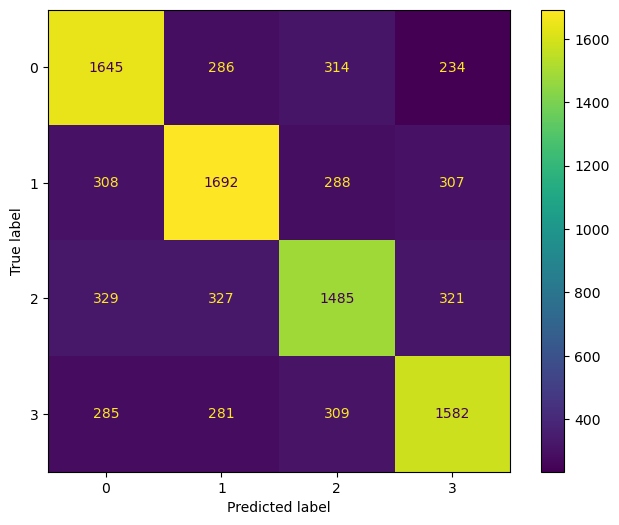

ROC AUC score {0: 0.8086132187511106, 1: 0.8040553583976506, 2: 0.7778182699162444, 3: 0.8024412139327215}


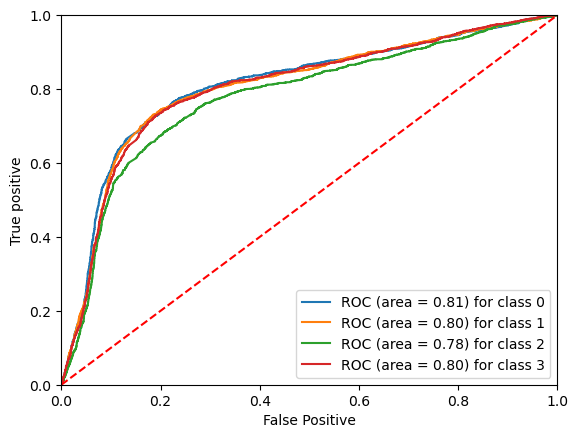

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import (confusion_matrix,
                            ConfusionMatrixDisplay,
                            precision_score,
                            recall_score,
                            accuracy_score,
                            f1_score,
                            roc_curve,
                            auc)

def plot_roc_auc(probs, y_true, n_class=4):
    fpr, tpr, roc_auc = dict(), dict(), dict()
    
    dummies = pd.get_dummies(y_true, drop_first=False).values
    for i in range(n_class):
        fpr[i], tpr[i], _ = roc_curve(dummies[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    print(f"ROC AUC score {roc_auc}")
    for i in range(n_class):
        plt.plot(fpr[i], tpr[i], label='ROC (area = %0.2f) for class %i' % (roc_auc[i], i))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel("True positive")
    plt.xlabel("False Positive")
    plt.legend()
    plt.show()


def evaluate_model(y_preds, y_true):
    """
    Generates a confusion matrix and calculates f1 scores,
    accuracy measures, recall and precision given predicted Ys
    and ground truth Ys.
    """
    conf = confusion_matrix(y_test, y_preds)
    
    print("All applicable scores are weighted")
    print(f"F1 Score : {f1_score(y_true, y_preds, average='weighted')}")
    print(f"Accuracy : {accuracy_score(y_true, y_preds)}")
    print(f"Recall   : {recall_score(y_true, y_preds, average='weighted')}")
    print(f"Precision: {precision_score(y_true, y_preds, average='weighted')}")
    
    fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
    display = ConfusionMatrixDisplay(conf)
    display.plot(ax=ax)
    plt.show()
    
    
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)
plot_roc_auc(clf.decision_function(x_test), y_test)

## Simple Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(verbose=True, max_iter=1000)
res = clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       102624     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.54102D+04    |proj g|=  9.75000D+01

At iterate   50    f=  4.26633D+04    |proj g|=  1.32250D+02

At iterate  100    f=  4.15803D+04    |proj g|=  1.12504D+02

At iterate  150    f=  4.14751D+04    |proj g|=  4.54579D+01

At iterate  200    f=  4.14652D+04    |proj g|=  2.52075D+00

At iterate  250    f=  4.14644D+04    |proj g|=  1.12895D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    285    315      1     0     0   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.8s finished


All applicable scores are weighted
F1 Score : 0.5591030304481288
Accuracy : 0.559291504052837
Recall   : 0.559291504052837
Precision: 0.5592896563167069


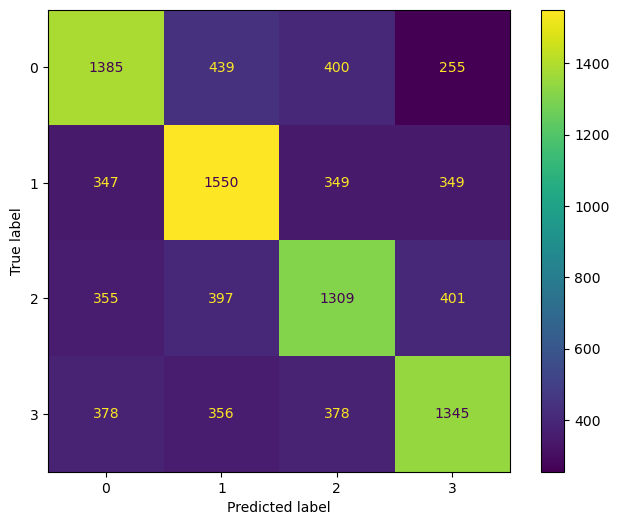

ROC AUC score {0: 0.7834207126930361, 1: 0.8032769102309065, 2: 0.7758959420477137, 3: 0.7795135783458501}


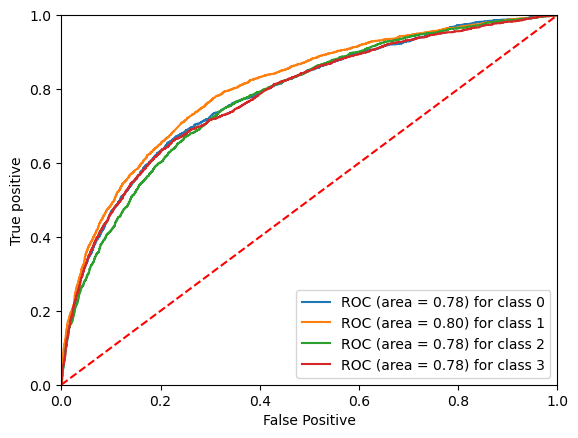

In [26]:
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)
plot_roc_auc(clf.decision_function(x_test), y_test)

## Grid Search With K-Neighbors Classification

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

pipe = Pipeline([('classifier', KNeighborsClassifier())])
param_grid = {
    'classifier__n_neighbors': list(range(3, 11)),
    'classifier__weights': ['uniform', 'distance'],
    'classifier__p': [2,3,4,5],
}

clf = GridSearchCV(pipe,
                  param_grid=param_grid,
                  cv=5,
                  n_jobs=20,
                  verbose=True)

best_clf = clf.fit(x_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
240 fits failed out of a total of 320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
240 fits failed with the following error:
Traceback (most recent call last):
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/parvus/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py", line 215, in fit
    return self._

All applicable scores are weighted
F1 Score : 0.6591761235390177
Accuracy : 0.655959171419994
Recall   : 0.655959171419994
Precision: 0.7097386688402005


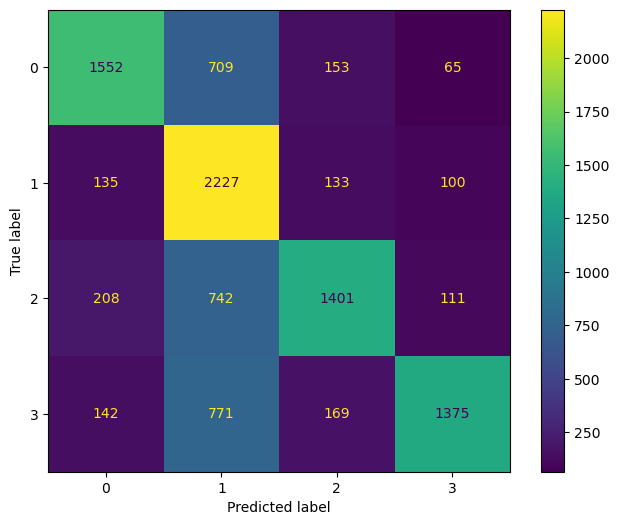

ROC AUC score {0: 0.8848354659308542, 1: 0.8804209438472408, 2: 0.8655897351871672, 3: 0.8827447813647389}


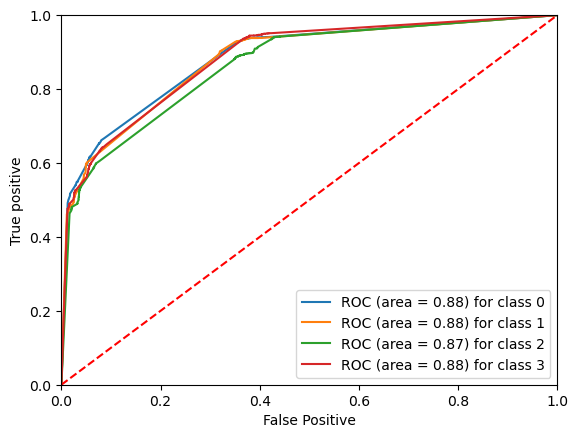

In [29]:
y_preds = best_clf.predict(x_test)
evaluate_model(y_preds, y_test)
plot_roc_auc(best_clf.predict_proba(x_test), y_test)

In [30]:
print(best_clf.best_score_)
print(best_clf.best_params_)

0.6154115586690019
{'classifier__n_neighbors': 6, 'classifier__p': 2, 'classifier__weights': 'distance'}


## Support Vector Machine Classification

In [33]:
from sklearn.svm import SVC

clf = SVC(verbose=True, cache_size=32_000, probability=True) # cache size specified in MB
clf.fit(x_train, y_train)

[LibSVM]..........*...*
optimization finished, #iter = 13569
obj = -6654.321066, rho = 0.363774
nSV = 13301, nBSV = 6884
Total nSV = 13301
..........*...*
optimization finished, #iter = 13593
obj = -6641.282645, rho = -0.748483
nSV = 13360, nBSV = 6897
Total nSV = 13360
..........*...*
optimization finished, #iter = 13674
obj = -6692.052091, rho = -0.704944
nSV = 13406, nBSV = 6958
Total nSV = 13406
..........*...*
optimization finished, #iter = 13596
obj = -6658.249839, rho = 0.465803
nSV = 13368, nBSV = 6936
Total nSV = 13368
..........*...*
optimization finished, #iter = 13737
obj = -6659.948989, rho = -0.102330
nSV = 13373, nBSV = 6867
Total nSV = 13373
.............*...*
optimization finished, #iter = 16753
obj = -7896.146471, rho = 0.321822
nSV = 16012, nBSV = 7981
..........*...*
optimization finished, #iter = 13697
obj = -6921.792871, rho = -0.261908
nSV = 13371, nBSV = 6933
Total nSV = 13371
..........*...*
optimization finished, #iter = 13616
obj = -6901.056928, rho = -0.2846

SVC(cache_size=32000, probability=True, verbose=True)

All applicable scores are weighted
F1 Score : 0.6732706216983234
Accuracy : 0.6733713599519664
Recall   : 0.6733713599519664
Precision: 0.674021220197709


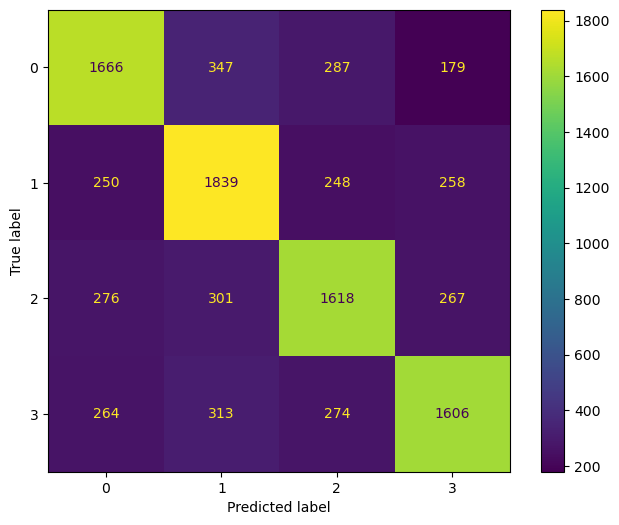

ROC AUC score {0: 0.8599919386729281, 1: 0.8667894410872907, 2: 0.8463856298919785, 3: 0.8581027051701149}


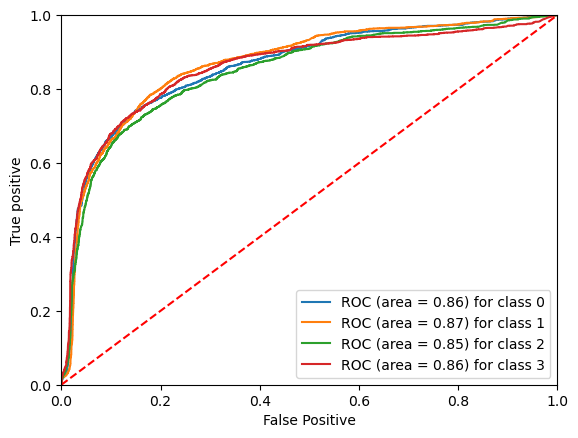

In [35]:
y_preds = clf.predict(x_test)
evaluate_model(y_preds, y_test)
plot_roc_auc(clf.predict_proba(x_test), y_test)